In [1]:

import gzip
import math
import numpy as  np
import random
import sklearn
import string
from collections import defaultdict
import json
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def parseData(file):
    for l in open(file,'r'):
        yield json.loads(l)

In [2]:
dataset2 = []
dataset2 = list(parseData('renttherunway_final_data.json'))

In [3]:
count = 0 
for i in dataset2:
    try:
        _ = i['weight']
    except:
        count+=1
print("Percentage of user did not enter weight: " , count/len(dataset2))

count = 0 
for i in dataset2:
    try:
        _ = i['height']
    except:
        count+=1
print("Percentage of user did not enter height: " , count/len(dataset2))

count = 0 
for i in dataset2:
    try:
        _ = i['bust size']
    except:
        count+=1
print("Percentage of user did not enter bust size: " , count/len(dataset2))

Percentage of user did not enter weight:  0.15571505733754362
Percentage of user did not enter height:  0.0035160794415821837
Percentage of user did not enter bust size:  0.09561970250955626


In [4]:
dataset2[1]

{'fit': 'fit',
 'user_id': '273551',
 'bust size': '34b',
 'item_id': '153475',
 'weight': '132lbs',
 'rating': '10',
 'rented for': 'other',
 'review_text': 'I rented this dress for a photo shoot. The theme was "Hollywood Glam and Big Beautiful Hats". The dress was very comfortable and easy to move around in. It is definitely on my list to rent again for another formal event. ',
 'body type': 'straight & narrow',
 'review_summary': 'I felt so glamourous!!!',
 'category': 'gown',
 'height': '5\' 6"',
 'size': 12,
 'age': '36',
 'review_date': 'June 18, 2013'}

In [5]:
## We see a large percentage of users selected fit. 


fit_count = defaultdict(int)
for i in dataset2:
    fit_count[i['fit']]+=1
fit_count

defaultdict(int, {'fit': 142058, 'small': 25779, 'large': 24707})

In [36]:
fittingPerUser = defaultdict(list)
fittingPerItem = defaultdict(list)
allFitting = []
bust_sizes = set()
for entry in dataset2:
    item_id = entry['item_id']
    user_id = entry['user_id']
    fit = entry['fit']
    bust = entry.get('bust size',None)
    # bust_sizes.add(weight)
    height = entry.get('height', None)
    weight = entry.get('weight', None)
    size = entry['size']
    if fit == "fit":
        fit = 3
    elif fit == "small":
        fit = 1
    elif fit == 'large':
        fit = 5
        
    fittingPerUser[user_id].append((item_id,fit))
    fittingPerItem[(item_id,size)].append((user_id,fit))
    

    
    if bust != None:
        bust = int(bust[:2])
        
    if height != None:
        numbers = []
        for letter in height:
            if letter.isnumeric():
                numbers.append(int(letter))
        height_in_cm = 0
        height_in_cm += numbers[0]*30.48
        inches = ''
        for number in numbers[1:]:
            inches += str(number)
            
        height_in_cm += int(inches)* 2.54
        height = height_in_cm
    
    if weight != None:
        weight = int(weight[:-3])
    allFitting.append((user_id, item_id, fit, bust ,height, weight,size))
    


In [37]:

print('Size of the dataset :', len(dataset2))
lengths = []
for u in fittingPerUser:
    lengths.append(len(fittingPerUser[u]))
print("average fitting per user :", np.array(lengths).mean())
print('number of unique users: ', len(lengths))
lengths = []
for i in fittingPerItem:
    lengths.append(len(fittingPerItem[i]))

print("average fitting per item :", np.array(lengths).mean())
print('number of unique items: ', len(lengths))

print('-----------------------------')
print("Remove users with too few reviews")
print('-----------------------------')
removed_user_set = set()
lengths = []
for u in fittingPerUser:
    if len(fittingPerUser[u])>2:
        lengths.append(len(fittingPerUser[u]))
    else:
        removed_user_set.add(u)
        
print("average fitting per user post filterng :", np.array(lengths).mean())
print("total number of users post filtering :", len(lengths))

removed_item_set = set()
lengths = []
for i in fittingPerItem:
    if len(fittingPerItem[i])>2:
        lengths.append(len(fittingPerItem[i]))
    else:
        removed_item_set.add(i)
print("average fitting per item post filterng :", np.array(lengths).mean())
print("total number of items post filtering :", len(lengths))


Size of the dataset : 192544
average fitting per user : 1.8238341968911918
number of unique users:  105571
average fitting per item : 6.248385526529288
number of unique items:  30815
-----------------------------
Remove users with too few reviews
-----------------------------
average fitting per user post filterng : 5.3576835730507195
total number of users post filtering : 15852
average fitting per item post filterng : 9.983508590472907
total number of items post filtering : 17403


In [41]:
### Setting up the data for training and testing

users = list(fittingPerUser.keys())
items = list(fittingPerItem.keys())
userIDs = {}
itemIDs = {}
print("Length of pre-cleaned data:", len(allFitting))

    
random.shuffle(allFitting)
# filtered_allFitting = []
# for u,i,f in allFitting:
#     if u in removed_user_set or i in removed_item_set :
#         continue
#     filtered_allFitting.append((u,i,f))
# print("Length of cleaned data:", len(filtered_allFitting))
filtered_allFitting  = allFitting
nTrain = int(len(filtered_allFitting)*0.8)
nTest = int(len(filtered_allFitting)-nTrain)
interactionsTrain =  filtered_allFitting[:nTrain]
interactionsTest = filtered_allFitting[nTrain:]

bust_list = []
height_list = []
weight_list = []


fittingPerUser_train = defaultdict(list)
fittingPerItem_train = defaultdict(list)

for u,i,f, b,h,w , size in interactionsTrain:
    # if u in removed_user_set or i in removed_item_set :
    #     continue
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not (i,size) in itemIDs: itemIDs[(i,size)] = len(itemIDs)
    
    if b != None: bust_list.append(b)
    if h != None: height_list.append(h)
    if w != None: weight_list.append(w)
    
    fittingPerUser_train[u].append((i,f))
    fittingPerItem_train[(i,size)].append((u,f))
    
# normalizing the features

bust_list = np.array(bust_list)
height_list = np.array(height_list)
weight_list = np.array(weight_list)

bust_average = bust_list.mean()
height_average = height_list.mean()
weight_average = weight_list.mean()

bust_std = bust_list.std()
height_std = height_list.std()
weight_std = weight_list.std()

user_space_full = {}

for u,i,f, b,h,w ,size  in interactionsTrain:
    if h!= None and w != None:
        user_space_full[u] = ((h-height_average)/height_std,
                        (w-weight_average)/weight_std)

print(len(user_space_full))
# keeping only the best user
userPerSizes  = defaultdict(list)
for user, size in user_space_full.items():
    userPerSizes[size].append(user)

inv_user_space = {}
for size in userPerSizes:
    best_user = None
    max_length = 0 
    for user in userPerSizes[size]:
        l = len(fittingPerUser_train[user])
        if l > max_length:
            max_length = l
            best_user = user
    inv_user_space[size] = best_user
print(len(inv_user_space))
user_space = {v: list(k) for k, v in inv_user_space.items()}



Length of pre-cleaned data: 192544
74773
1726


In [44]:
itemIDs

{('153475', 4): 0,
 ('1603811', 20): 1,
 ('240913', 8): 2,
 ('943349', 39): 3,
 ('1539576', 4): 4,
 ('146684', 1): 5,
 ('364172', 12): 6,
 ('158028', 36): 7,
 ('985499', 17): 8,
 ('183945', 8): 9,
 ('169179', 24): 10,
 ('644706', 16): 11,
 ('757135', 12): 12,
 ('638318', 8): 13,
 ('152836', 8): 14,
 ('2821340', 14): 15,
 ('134849', 28): 16,
 ('1770781', 4): 17,
 ('305868', 12): 18,
 ('497719', 8): 19,
 ('1361162', 4): 20,
 ('1146287', 16): 21,
 ('425423', 4): 22,
 ('1961311', 8): 23,
 ('136110', 12): 24,
 ('859692', 12): 25,
 ('405907', 1): 26,
 ('1515649', 20): 27,
 ('132738', 5): 28,
 ('1317747', 12): 29,
 ('1698815', 4): 30,
 ('204063', 28): 31,
 ('1226293', 4): 32,
 ('126335', 12): 33,
 ('1661761', 16): 34,
 ('193179', 12): 35,
 ('1384766', 8): 36,
 ('1689209', 8): 37,
 ('1773356', 9): 38,
 ('450618', 24): 39,
 ('1892058', 12): 40,
 ('370717', 4): 41,
 ('636233', 4): 42,
 ('493510', 20): 43,
 ('921642', 14): 44,
 ('181453', 16): 45,
 ('1678888', 12): 46,
 ('1503791', 16): 47,
 ('34

In [80]:

import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(0.01)
# mean_fitting = np.array([i[2] for i in allFitting]).mean()


class LatentFactorModel(tf.keras.Model):
    def __init__(self,  K, lamb1, lamb2):
        super(LatentFactorModel, self).__init__()
        # Initialize to average
        # self.alpha = tf.Variable(mu,dtype='float32')
        # Initialize to small random values

        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001),dtype='float32')
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001),dtype='float32')
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001),dtype='float32')
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001),dtype='float32')
        self.lamb1 = lamb1
        self.lamb2 = lamb2
        # self.delta = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001),dtype='float32')

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        p = 3 + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
                # self.delta[i]*size
        return p

    # Regularizer
    def reg(self):
        return self.lamb1 * (tf.reduce_sum(self.betaU**2) +\
                            tf.reduce_sum(self.betaI**2)) +\
                            self.lamb2*(tf.reduce_sum(self.gammaU**2) +\
                            tf.reduce_sum(self.gammaI**2))
    
    # Prediction for a sample of instances
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        # s = tf.convert_to_tensor(sampleS, dtype=tf.int32)
        # size = tf.convert_to_tensor(size, dtype=tf.float32)
        
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        # delta = tf.nn.embedding_lookup(self.delta, s)
        pred = 3 + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1) 
               
        return pred
    
    # Loss
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)
        return tf.nn.l2_loss(pred - r) / len(sampleR)

# %%
def trainingStep(model, small, fit, large):
    Nsamples = 60000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR, sampleS , sizes = [], [], [], [], []
        for _ in range(Nsamples//3):

            u,i,r,s = random.choice(small)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[(i,s)])
            sampleR.append(r)
            # sampleS.append(itemIDs[i])
            # sizes.append(s)
            
            u,i,r,s = random.choice(fit)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[(i,s)])
            sampleR.append(r)
            # sampleS.append(itemIDs[i])
            # sizes.append(s)
            
            u,i,r,s = random.choice(large)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[(i,s)])
            sampleR.append(r)
            # sampleS.append(itemIDs[i])
            # sizes.append(s)
            
        loss = model(sampleU,sampleI,sampleR)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

# %%
modelLFM = LatentFactorModel( 4, 0.00008,0.00002)

# spliting the training based on fit:



In [81]:

small, fit, large = [], [], []

for u,i,r, _1,_2,_3, size in interactionsTrain:
    if r == 1:
        small.append((u,i,r,size))
    elif r == 3:
        fit.append((u,i,r,size))
    elif r == 5:
        large.append((u,i,r,size))

for i in range(300):
    obj = trainingStep(modelLFM, small, fit,large)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))


iteration 10, objective = 1.2022694
iteration 20, objective = 1.1077509
iteration 30, objective = 1.0478482
iteration 40, objective = 0.99798584
iteration 50, objective = 0.9534953
iteration 60, objective = 0.91342586
iteration 70, objective = 0.8828656
iteration 80, objective = 0.86392784
iteration 90, objective = 0.85236955
iteration 100, objective = 0.84748316
iteration 110, objective = 0.84556085
iteration 120, objective = 0.8467841
iteration 130, objective = 0.84528095
iteration 140, objective = 0.8415663
iteration 150, objective = 0.8403099
iteration 160, objective = 0.84151924
iteration 170, objective = 0.8397087
iteration 180, objective = 0.84251094
iteration 190, objective = 0.8362995
iteration 200, objective = 0.83672535
iteration 210, objective = 0.8397558
iteration 220, objective = 0.8372321
iteration 230, objective = 0.83643854
iteration 240, objective = 0.8368113
iteration 250, objective = 0.8360001
iteration 260, objective = 0.83673024
iteration 270, objective = 0.833195

In [53]:
modelLFM.alpha

AttributeError: 'LatentFactorModel' object has no attribute 'alpha'

In [48]:
def out_to_fit(x):
    if x <=2:
        return 1
    elif x <= 4:
        return 3
    else:
        return 5
    
    
def find_nearest_user(user_space, b,h,w ):
    
    global height_average
    global height_std
    global weight_average
    global weight_std
    
    if h!= None and w != None:
        features = np.array([(h-height_average)/height_std,(w-weight_average)/weight_std])
        distance = 999999
        closest_user = None
        for user in user_space:
            distance2 = np.sum((features - np.array(user_space[user]))**2)
            if distance > distance2:
                closest_user = user
                distance = distance2
        return closest_user
    else:
        return None
    
correct = 0 
count = 0
for u,i,f, b,h,w  in interactionsTest:
    if u not in userIDs and i in itemIDs:
        closest_user =  find_nearest_user(user_space, b,h,w )
        if closest_user == None:
            ### U 
            average_item_fit = 0
            for u,f in fittingPerItem_train[i]:
                average_item_fit += f
            average_item_fit /= len(fittingPerItem_train[i])
            prediction = out_to_fit(average_item_fit)
        else:
            prediction = out_to_fit(modelLFM.predict(userIDs[closest_user],itemIDs[i]).numpy())
            
    elif u in userIDs and i not in itemIDs:
        continue
        
    elif u not in userIDs and i not in itemIDs:
        continue
    else:
        prediction = out_to_fit(modelLFM.predict(userIDs[u],itemIDs[i]).numpy())
    
    if prediction == f:
        correct += 1 

print(correct / len(interactionsTest))


ValueError: too many values to unpack (expected 6)

In [12]:
userIDs['452823']

65669

In [78]:
def average_auc_score(test):
    pred = []
    target = []

    for u,i,f, b,h,w ,s in test:
        # print(f)
        if u not in userIDs and (i,s) in itemIDs:
            closest_user =  find_nearest_user(user_space, b,h,w )
            if closest_user == None:
                ### U 
                average_item_fit = 0
                for u,f in fittingPerItem_train[(i,s)]:
                    average_item_fit += f
                average_item_fit /= len(fittingPerItem_train[(i,s)])
                prediction = average_item_fit

            else:
                prediction = modelLFM.predict(userIDs[closest_user],itemIDs[(i,s)]).numpy()

        elif u in userIDs and (i,s) not in itemIDs:
            prediction = 3
            
        elif u not in userIDs and (i,s) not in itemIDs:
            prediction = 3
        else:
            prediction = modelLFM.predict(userIDs[u],itemIDs[(i,s)]).numpy()   
        predict = max(min(prediction,5), 1) 
        pred.append(predict)
        target.append(f)

    pred_prob = np.zeros((len(test),3))
    for val_ind in range(len(pred)):
        val = pred[val_ind]
        prob1 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-1)/0.85)**2)
        prob2 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-3)/0.85)**2)
        prob3 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-5)/0.85)**2)
        sum_ = prob1 + prob2 + prob3

        pred_prob[val_ind][0] = prob1/sum_
        pred_prob[val_ind][1] = prob2/sum_
        pred_prob[val_ind][2] = prob3/sum_
        
        
    print(pred_prob[:1000,:])
    print(pred[:1000])
    
    AUC = []
    target_map = [1,3,5]
    weights = np.array([0.13,0.73,0.12])
    legend_map = ['ROC cureve of class small ( area = ','ROC cureve of class fit ( area = ','ROC cureve of class large ( area = ']
    for i in range(3):
        target_sp = []
        for t in target: 
            if t == target_map[i]:
                target_sp.append(1)
            else:
                target_sp.append(0)
                
        
        roc_score = roc_auc_score(target_sp, pred_prob[:,i], average='weighted')
        AUC.append(roc_score)

        fpr, tpr, thresholds = roc_curve(target_sp, pred_prob[:,i])
        plt.plot(fpr, tpr, label=legend_map[i]+str(roc_score)[:4] + ')')
    plt.plot([0,0.5,1],[0,0.5,1],'--',color='k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Latent variable Model ROC curves')
    plt.legend()
    plt.savefig('AUC.png')

    return np.array(AUC) @ weights


[[0.05429831 0.88841579 0.0572859 ]
 [0.03168661 0.87343149 0.0948819 ]
 [0.13048866 0.84780338 0.02170796]
 ...
 [0.02643591 0.86263177 0.11093231]
 [0.35998125 0.63559609 0.00442266]
 [0.14507996 0.83593803 0.01898201]]
[3.0096745, 3.1980984, 2.6760297, 3.2250445, 2.7088864, 3.475084, 2.750958, 3.0086536, 2.8840284, 3.1915808, 3.1027448, 2.4864717, 2.8041282, 3.675324675324675, 3.295234, 3.26588, 3.0102813, 2.9013238, 3.2272973, 2.9458055, 3.3682425, 3.7160256, 2.5547373, 3.007456, 2.995223, 2.38164, 3.8071134, 2.7775712, 2.3572156, 3.687845, 4.230719, 2.4103293, 3.6666666666666665, 5, 1, 2.8416092, 2.931796, 3.2498627, 2.921274, 3.4053247, 3.357481, 3.0451946, 3.5575767, 3.2883222, 1.8479931, 1, 3.2095238095238097, 3.0775993, 3.1810472, 3.22124, 2.5663886, 3.1731396, 3.3045058, 2.99985, 2.7724726, 2.4629617, 3.0, 3.215523, 2.8080812, 2.8386943, 3.129857, 2.839994, 3.4699752, 2.5930493, 3.1017506, 4.5858974, 2.5723329, 2.7245524, 3.0024526, 3.179861, 3.4, 2.8315575, 3.0756235, 2.8942

0.5866085011762312

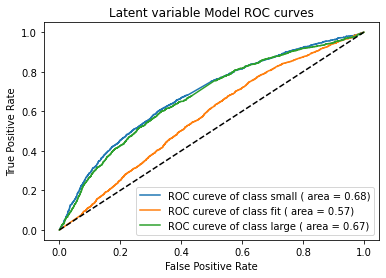

In [79]:
average_auc_score(interactionsTest[:10000])

In [ ]:
import torch
torch.cuda.is_available()


False

In [ ]:
!conda install pytorch torchvision torchaudio pytorch-cuda=11.6 -c pytorch -c nvidia

^C
